# Deep Learning with PyTorch : Build a Generative Adversarial Network

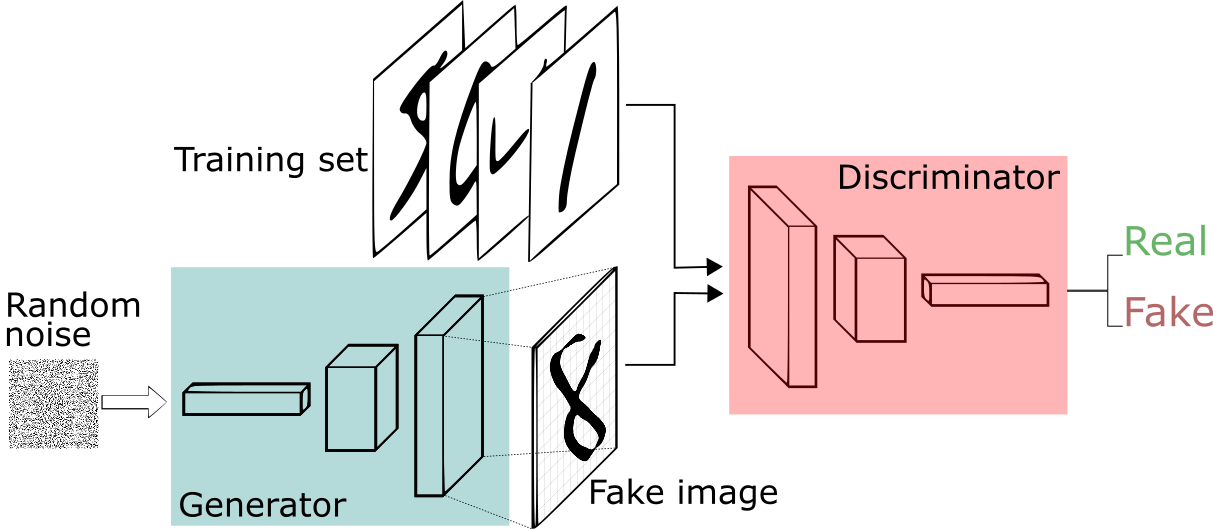

In [47]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [48]:
device = "cuda" # image= image.to(device)

batch_size = 128 # trainloader, train loop

noise_dim = 64 # generator model

# optimizer parameters for Adam optimizer
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables

epochs = 20

# Load MNIST Dataset

In [49]:
from torchvision import datasets, transforms as T

In [50]:
train_augs = T.Compose([
                  T.RandomRotation((-20, +20)),
                  T.ToTensor() # (h,w,c) -> (c, h, w)
])

In [51]:
trainset = datasets.MNIST('MNIST/', download = True, train = True, transform = train_augs)

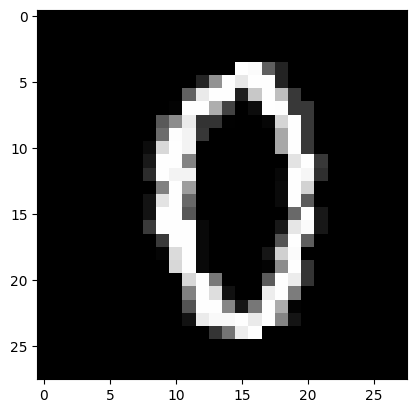

In [52]:
image, label = trainset[1000]

plt.imshow(image.squeeze(), cmap ='gray')

In [53]:
print ("total images present in trainset are :", len(trainset))

total images present in trainset are : 60000


# Load Dataset Into Batches

In [54]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [55]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [56]:
print ("Total nuber of batches in trainloader : ", len(trainloader))

Total nuber of batches in trainloader :  469


In [57]:
dataiter = iter(trainloader)

#images, _ = dataiter.next()
images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [58]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

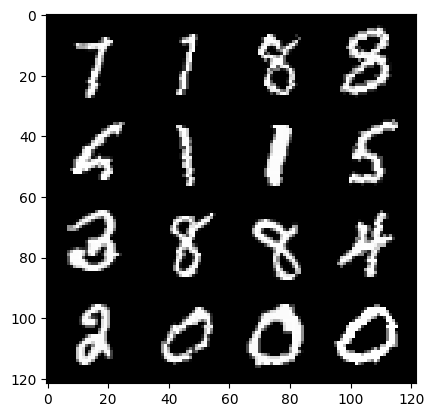

In [59]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network

In [60]:
#In case if torch summary is not installed

!pip install torchsummary

In [61]:
from torch import nn
from torchsummary import summary

In [62]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [63]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
  )

In [64]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = get_disc_block(1,16,(3,3),2)
    self.block_2 = get_disc_block(16,32,(5,5),2)
    self.block_3 = get_disc_block(32,64,(5,5),2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features= 64, out_features=1)
  def forward(self,images):

    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [65]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [66]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [67]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False) :
  if final_block == True:
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [68]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim,256,(3,3),2)
    self.block_2 = get_gen_block(256,128,(4,4),1)
    self.block_3 = get_gen_block(128,64,(3,3),2)

    self.block_4 = get_gen_block(64,1,(4,4),2, final_block =True)


  def forward(self,r_noise_vec):
    #(bs, noise_dim) -> (bs, noise_dim,1,1)
    x = r_noise_vec.view(-1,self.noise_dim,1,1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [69]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [70]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [71]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [72]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss


In [73]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))


In [74]:
dir(torch.nn)

['AdaptiveAvgPool1d',
 'AdaptiveAvgPool2d',
 'AdaptiveAvgPool3d',
 'AdaptiveLogSoftmaxWithLoss',
 'AdaptiveMaxPool1d',
 'AdaptiveMaxPool2d',
 'AdaptiveMaxPool3d',
 'AlphaDropout',
 'AvgPool1d',
 'AvgPool2d',
 'AvgPool3d',
 'BCELoss',
 'BCEWithLogitsLoss',
 'BatchNorm1d',
 'BatchNorm2d',
 'BatchNorm3d',
 'Bilinear',
 'CELU',
 'CTCLoss',
 'ChannelShuffle',
 'CircularPad1d',
 'CircularPad2d',
 'CircularPad3d',
 'ConstantPad1d',
 'ConstantPad2d',
 'ConstantPad3d',
 'Container',
 'Conv1d',
 'Conv2d',
 'Conv3d',
 'ConvTranspose1d',
 'ConvTranspose2d',
 'ConvTranspose3d',
 'CosineEmbeddingLoss',
 'CosineSimilarity',
 'CrossEntropyLoss',
 'CrossMapLRN2d',
 'DataParallel',
 'Dropout',
 'Dropout1d',
 'Dropout2d',
 'Dropout3d',
 'ELU',
 'Embedding',
 'EmbeddingBag',
 'FeatureAlphaDropout',
 'Flatten',
 'Fold',
 'FractionalMaxPool2d',
 'FractionalMaxPool3d',
 'GELU',
 'GLU',
 'GRU',
 'GRUCell',
 'GaussianNLLLoss',
 'GroupNorm',
 'Hardshrink',
 'Hardsigmoid',
 'Hardswish',
 'Hardtanh',
 'HingeEmbed

In [75]:
nn.BCEWithLogitsLoss()

BCEWithLogitsLoss()

# Training Loop

Epoch: 1| D_loss :0.6863176693031783, |G_loss : 0.6888425295541027


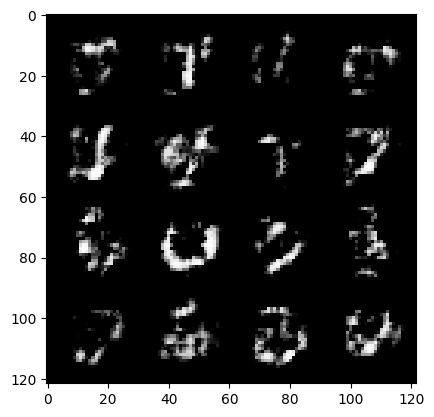

Epoch: 2| D_loss :0.6772494459711412, |G_loss : 0.7137509186638952


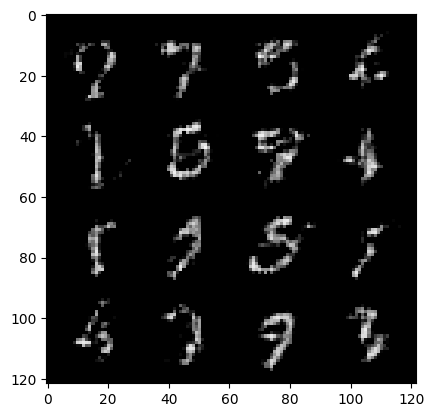

Epoch: 3| D_loss :0.6302894601689727, |G_loss : 0.7655550728220422


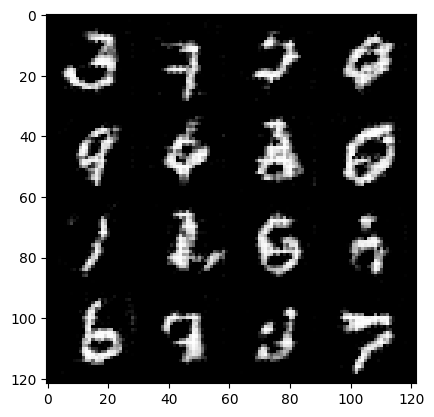

Epoch: 4| D_loss :0.5982647303070849, |G_loss : 0.8112454258048458


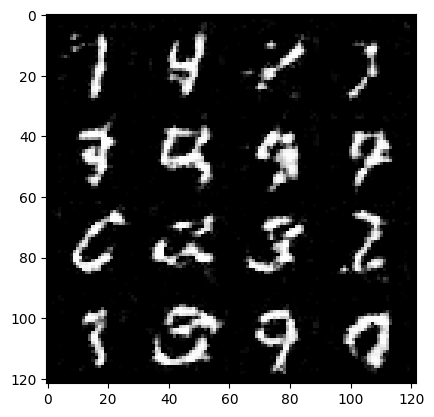

Epoch: 5| D_loss :0.5843402514579707, |G_loss : 0.8432783470479156


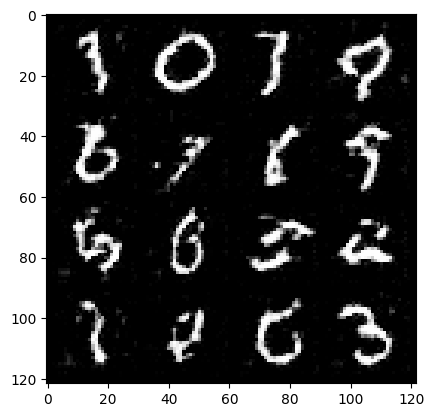

Epoch: 6| D_loss :0.5771947327707367, |G_loss : 0.8677839331789565


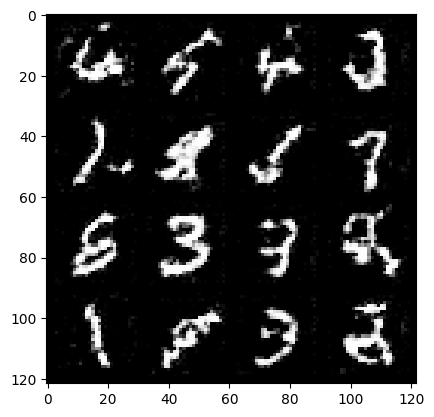

Epoch: 7| D_loss :0.5807925531350727, |G_loss : 0.8796716038860491


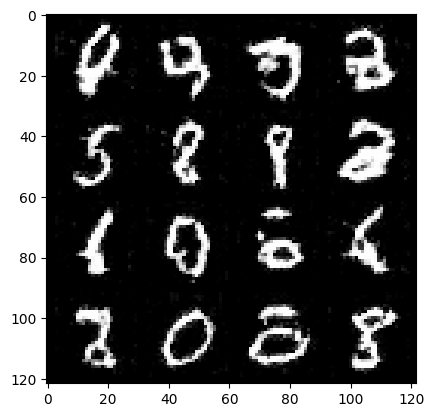

Epoch: 8| D_loss :0.5903189963877582, |G_loss : 0.8737562865590744


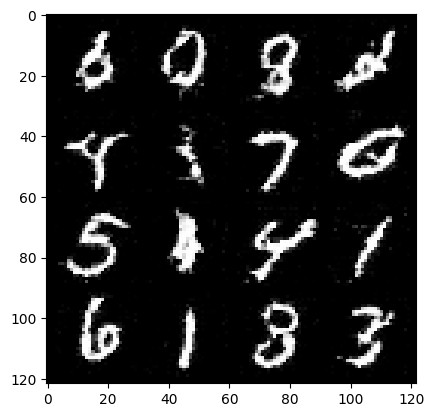

Epoch: 9| D_loss :0.5980469351892532, |G_loss : 0.8735023548862318


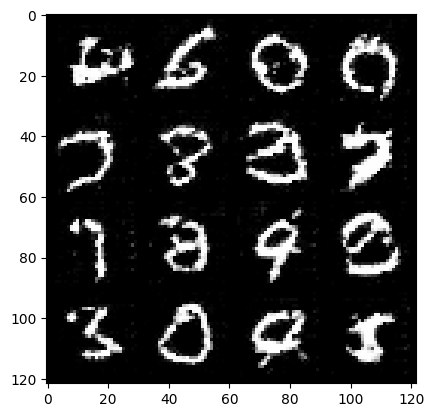

Epoch: 10| D_loss :0.6085960792580138, |G_loss : 0.8665963552399739


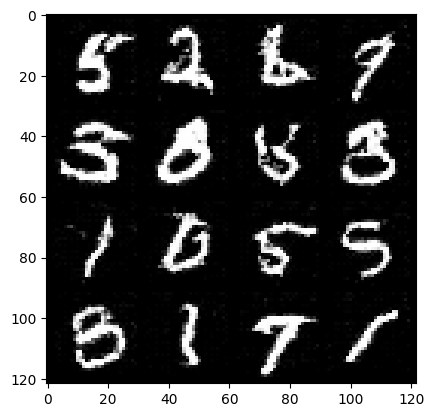

Epoch: 11| D_loss :0.6104043166774676, |G_loss : 0.8650831972866424


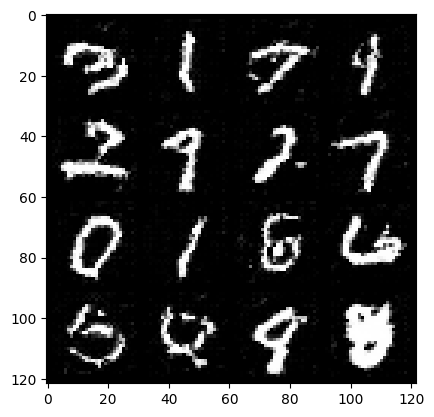

Epoch: 12| D_loss :0.6150419896345403, |G_loss : 0.860855120204405


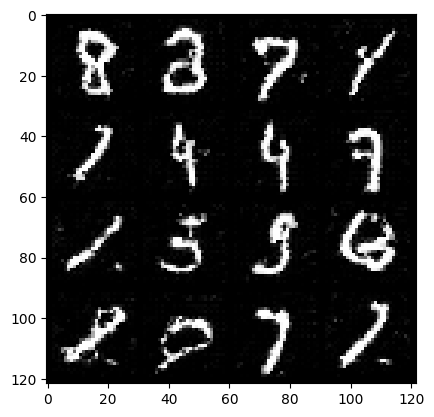

Epoch: 13| D_loss :0.617945821554676, |G_loss : 0.8579402135125102


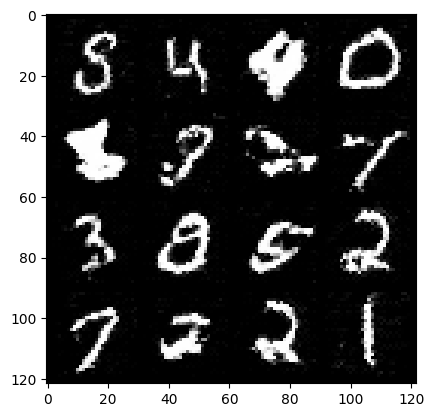

Epoch: 14| D_loss :0.6212069398558724, |G_loss : 0.8555232581299251


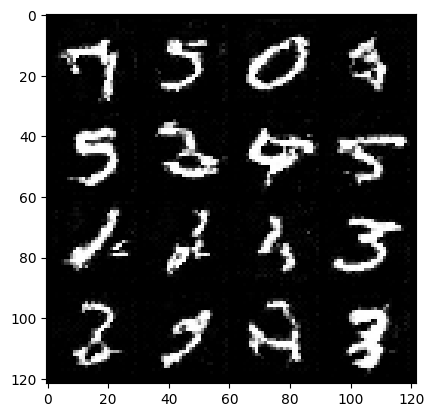

Epoch: 15| D_loss :0.622248368349665, |G_loss : 0.8566169485862829


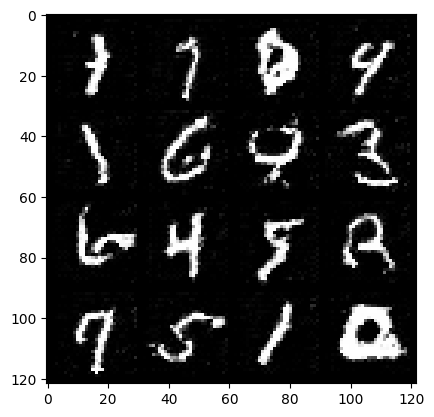

Epoch: 16| D_loss :0.6221958382297427, |G_loss : 0.8556582667171828


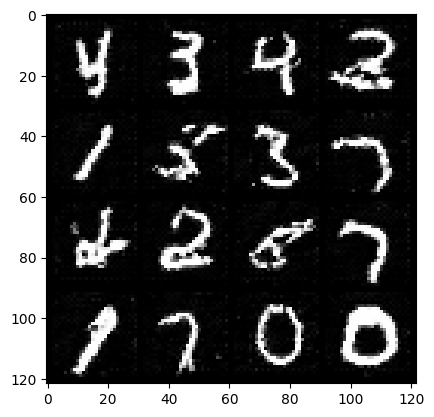

Epoch: 17| D_loss :0.6236651848628323, |G_loss : 0.8557899063075783


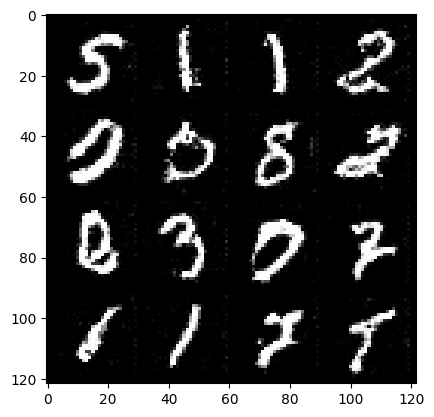

Epoch: 18| D_loss :0.6241265582377469, |G_loss : 0.8573589608359184


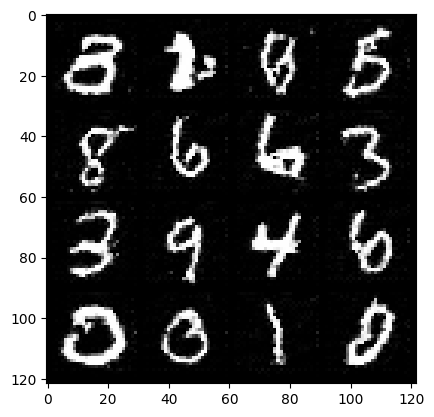

Epoch: 19| D_loss :0.6264439073961172, |G_loss : 0.8581263159892198


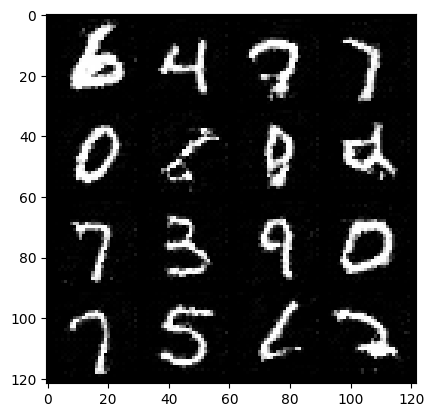

Epoch: 20| D_loss :0.6258190162400447, |G_loss : 0.8587285552197682


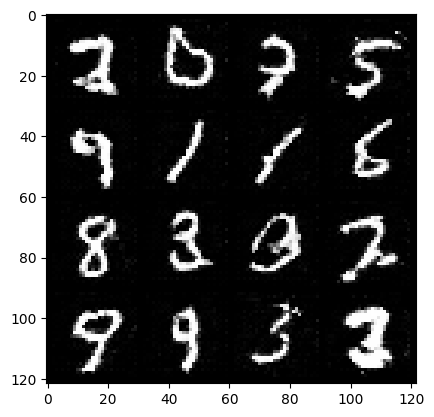

In [78]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0
  for real_img, _ in trainloader:

    real_img= real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device= device)

    # find loss and update weights for D

    D_opt.zero_grad()
    #D_opt.use_cleargrads(use=False)

    fake_img = G(noise)

    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = ( D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    # find loss and update weights for G
    G_opt.zero_grad()
    #G_opt.use_cleargrads(use=False)

    noise = torch.randn(batch_size, noise_dim, device= device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch: {}| D_loss :{}, |G_loss : {}".format(i+1, avg_d_loss,avg_g_loss ))

  show_tensor_images(fake_img)

In [79]:
print(torch.__version__)

2.3.0+cu121


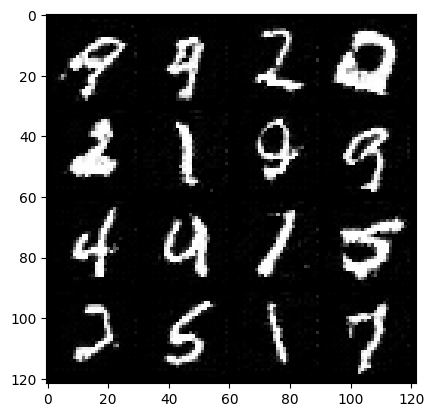

In [80]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya